In [1]:
import kagglehub
import struct
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from array import array
from os.path import join
from torch.utils.data import TensorDataset, DataLoader

/Users/deepakramalingam/Documents/Projects/deep-learning-exercises/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#
# MNIST Data Loader Class from https://www.kaggle.com/code/hojjatk/read-mnist-dataset
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

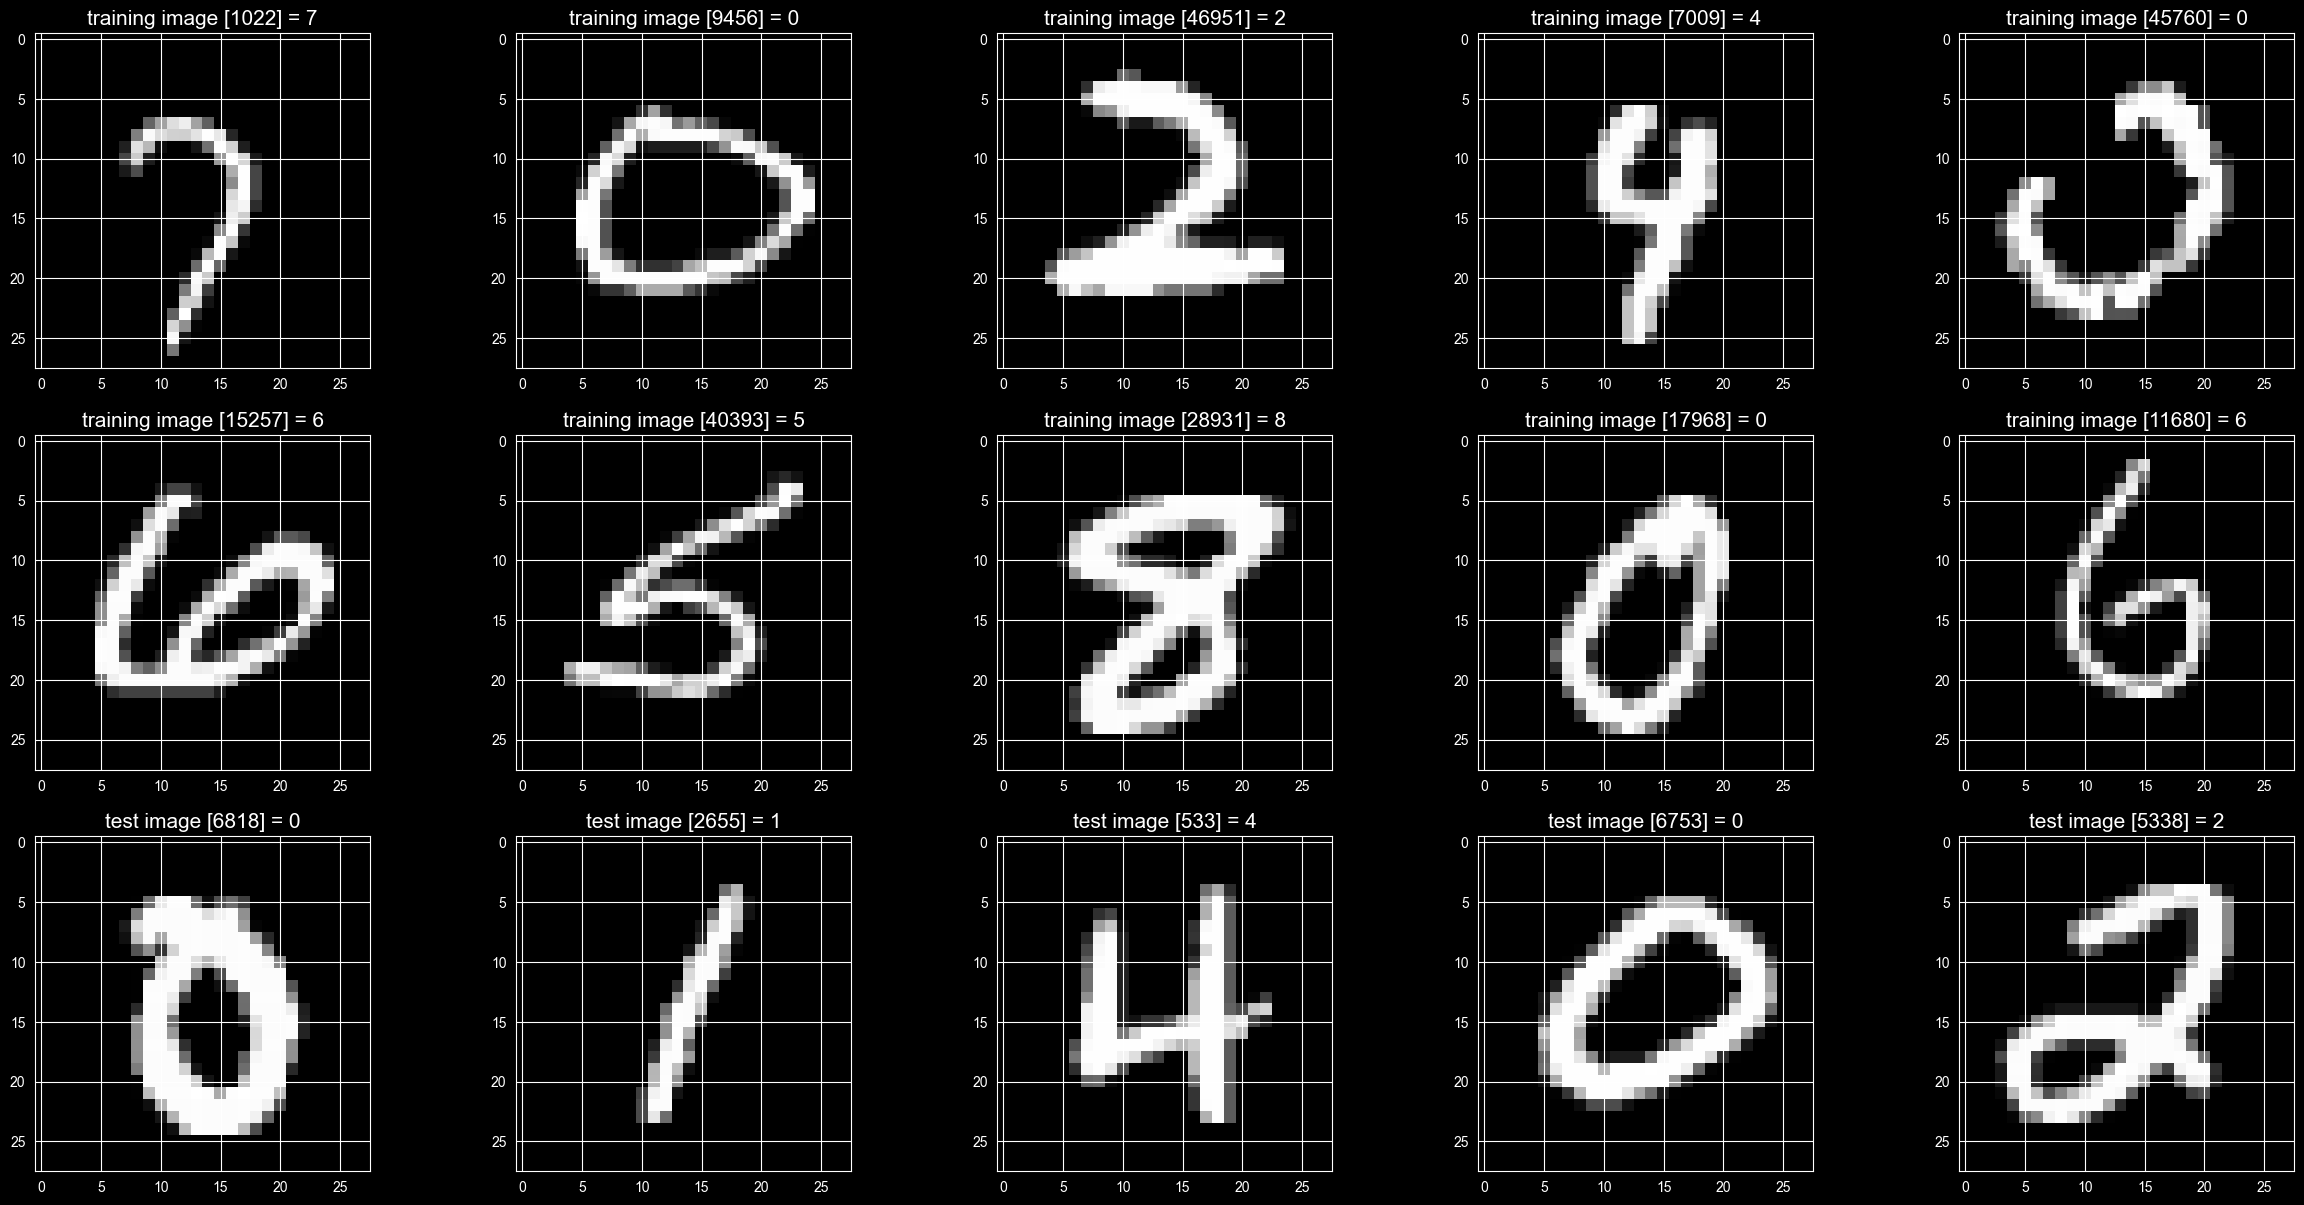

In [3]:
#
# Verify Reading Dataset via MnistDataloader class (reference: https://www.kaggle.com/code/hojjatk/read-mnist-dataset)
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = kagglehub.dataset_download("hojjatk/mnist-dataset")
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [4]:
# 1. init random weights
# 2. loop:
#     2a. predict
#     2b. loss function
#     2c. gradient
#     2d. update weights

# 0. create dataset
def create_data_loader(x, y):
    x_train_np = np.array(x)
    y_train_np = np.array(y)

    # flatten and normalize input data
    x_train_tensor = torch.tensor(x_train_np).float().view(-1, 28 * 28) / 255.0
    y_train_tensor = torch.tensor(y_train_np).long()

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # create batches for sgd
    batch_size = 64
    return DataLoader(train_dataset, batch_size, True)

train_loader = create_data_loader(x_train, y_train)

# 1. params, bias, and activation functions
net = nn.Sequential(
    nn.Linear(28 * 28, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 10)
)

# optimizer
opt = optim.Adam(net.parameters(), lr=0.001)

# criterion
criterion = nn.CrossEntropyLoss()
loss = None

# 2. loop
epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # 2a. predict
        y_pred = net(images)
        # 2b. loss function
        loss = criterion(y_pred, labels)
        # 2c. gradient
        opt.zero_grad()
        loss.backward()
        # 2d. update weights
        opt.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} complete. Avg Loss: {running_loss/len(train_loader):.4f}")

Epoch 1 complete. Avg Loss: 0.2615
Epoch 2 complete. Avg Loss: 0.1069
Epoch 3 complete. Avg Loss: 0.0792
Epoch 4 complete. Avg Loss: 0.0615
Epoch 5 complete. Avg Loss: 0.0525
Epoch 6 complete. Avg Loss: 0.0446
Epoch 7 complete. Avg Loss: 0.0388
Epoch 8 complete. Avg Loss: 0.0334
Epoch 9 complete. Avg Loss: 0.0313
Epoch 10 complete. Avg Loss: 0.0308
Epoch 11 complete. Avg Loss: 0.0268
Epoch 12 complete. Avg Loss: 0.0243
Epoch 13 complete. Avg Loss: 0.0213
Epoch 14 complete. Avg Loss: 0.0254
Epoch 15 complete. Avg Loss: 0.0215
Epoch 16 complete. Avg Loss: 0.0196
Epoch 17 complete. Avg Loss: 0.0193
Epoch 18 complete. Avg Loss: 0.0212
Epoch 19 complete. Avg Loss: 0.0193
Epoch 20 complete. Avg Loss: 0.0168


Overall Accuracy: 98.38%


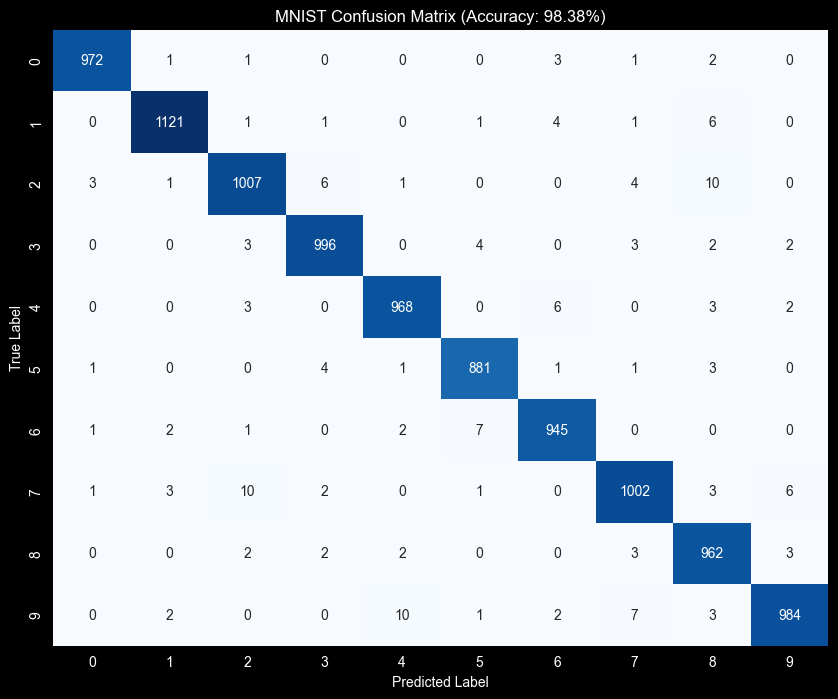

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model to evaluation mode
net.eval()

# Create the test loader
test_loader = create_data_loader(x_test, y_test)

all_preds = []
all_labels = []

# Iterate over the test data without tracking gradients
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        # Move to CPU and convert to numpy for sklearn
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {accuracy*100:.2f}%")

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'MNIST Confusion Matrix (Accuracy: {accuracy*100:.2f}%)')
plt.show()